In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import repeat


from snewpy import snowglobes
from astropy import units as u
from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models.ccsn import *
from snewpy.flavor_transformation import AdiabaticMSW


SNOwGLoBES_path = "/Users/sierra/Desktop/neutrino_fall_2022/dependencies/snowglobes"
SNEWPY_models_base = "/Users/sierra/Desktop/neutrino_fall_2022/dependencies/SNEWPY_models"  # directory containing SNEWPY models

# set parameters that don't vary over all models
# set distance in kpc
distance = 1.0

# set SNOwGLoBES detector to use
detector = "ar40kt"

# set desired flavor transformation
transformation = 'AdiabaticMSW_NMO'

window_tstart = 0.1015 # Fornax adjusted time bins
window_tend = 4.1015
window_bins = 800 # .005 s time bin

window_tstart_burst = -0.0505 # Fornax adjusted time bins
window_tend_burst = 0.1015
window_bins_burst = 76 # .002 s time bin


tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
tend = tstart + (window_tend - window_tstart) / window_bins 
tmid = (tstart + tend) * 0.5 

tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
tmid_burst = (tstart_burst + tend_burst) * 0.5 

tstart = np.append(tstart_burst, tstart)
tend = np.append(tend_burst, tend)

# rename factor
change_to_s = window_bins / (window_tend - window_tstart) / 1000
change_to_s_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) / 1000

# number of lines in dat file
num_lines = 200

extended_time = [x for item in tstart for x in repeat(item, num_lines)]
extended_time = np.array_split(extended_time, window_bins + window_bins_burst)

plt.rcParams.update({'font.size': 16})


In [2]:
# make new colorbar

# opening the file in read mode
new_colorbar = open("/Users/sierra/Desktop/neutrino/colormap_updated.txt", "r")
  
# reading the file
data = new_colorbar.read()
  
# replacing end splitting the text 
# when newline ('\n') is seen.
c = data.split('\n')

new_colorbar.close()

cm_u = mpl.colors.ListedColormap(c)

In [11]:
def get_interaction_arrays(energy_inst, interaction_inst, summed_data, channel, file_directory):
    channel_type = summed_data
    sorted_dir = os.listdir(file_directory)
    sorted_dir = sorted(sorted_dir, key=lambda x:float(re.findall("(\d+)", x)[-2]))
    # get all unsmeared files - need underscore, otherwise code will get confused
    interaction_type_lst = [s for s in sorted_dir if "_smeared" in s]
    # get all unweighted files - need underscore, otherwise code will get confused
    interaction_type_lst = [s for s in interaction_type_lst if "_unweighted" in s]
    for filename in interaction_type_lst:
        #print(filename)
        with open(os.path.join(file_directory, filename), 'r') as f:
            interaction_sum = 0
            next(f)
            next(f) # skip string headers
            if channel == "nue_Ar40":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[1]))
                    interaction_sum += float(line.split()[1])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "nuebar_Ar40":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[2]))
                    interaction_sum += float(line.split()[2])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "nc":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[3]))
                    interaction_sum += float(line.split()[3])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "e":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[4]))
                    interaction_sum += float(line.split()[4])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "cc":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[1]) + float(line.split()[2]))
                    interaction_sum += float(line.split()[1]) + float(line.split()[2])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "all":
                for line in f:
                    zero += float(line.split()[0])
                    one += float(line.split()[1])
                    two += float(line.split()[2])
                    three += float(line.split()[3])
                    four += float(line.split()[4])
                    five += float(line.split()[5])
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[1]) + float(line.split()[2]) + float(line.split()[3]) + float(line.split()[4]) + float(line.split()[5]))
                    interaction_sum += float(line.split()[1]) + float(line.split()[2]) + float(line.split()[3]) + float(line.split()[4]) + float(line.split()[5])
                channel_type.append(interaction_sum)
                
                interaction_sum = 0
                print("column 0", zero)
                print("column 1", one)
                print("column 2", two)
                print("column 3", three)
                print("column 4", four)
                print("column 5", five)
                print("sum of columns (except energy) is", one + two + three+ four + five)
    return channel_type
                

In [40]:
def sort_by_phase(tstart, window_tend_burst):
    high_res = []
    for i in tstart:
        if i <= window_tend_burst:
            high_res.append(i)
    
    burst, cooling = [], []
    for i in (tstart):
        if i <= window_tend_burst:
            burst.append(i)
        #if i > 0.1 and i <= 0.5:
        #    accretion.append(i)
        if i > window_tend_burst: #.5
            cooling.append(i)
    return burst, cooling, high_res


def extend_phase(burst, cooling):
    ext_burst = [x for item in burst for x in repeat(item, num_lines)]
    ext_burst = np.array_split(ext_burst,len(burst))

    ext_cooling = [x for item in cooling for x in repeat(item, num_lines)]
    ext_cooling = np.array_split(ext_cooling,len(cooling))
    
    return ext_burst, ext_cooling

def shape_and_scale_interaction(inst_interaction, energy, high_res):
    l = np.array_split(inst_interaction, window_bins + window_bins_burst)
    l = [value * (1/4) for value in l] # 10 kt detector, scales linearly
    e = np.array_split(energy, window_bins + window_bins_burst)
    e = [value * 1000 for value in e] #get to MeV
    
    return l, e

def scale_interaction(l, high_res):
    #print(high_res)
    #l = [value * change_to_s_burst for value in l[:len(high_res) -1]] + [value * change_to_s for value in l[len(high_res) -1 :]]
    list1 = [value * (1/4) for value in l] # 10 kt detector, scales linearly
    return list1
    
    
def scale_detector(l, high_res):
    #print(high_res)
    #l = [value * factor_to_rescale_burst for value in l[:len(high_res) -1]] + [value * factor_to_rescale for value in l[len(high_res) -1:]]
    list1 = [value * (1/4) for value in l] # 10 kt detector, scales linearly
    return list1

def scale_detector_res(l, burst, change_to_s_burst, change_to_s):
    list1 = [value * change_to_s_burst for value in l[:len(burst) -1]] 
    list2 = [value * change_to_s for value in l[len(burst) -1:]]
    list1.extend(list2)
    list3 = [value * (1/4) for value in list1] # 10 kt detector, scales linearly
    return list3
    
    
def formatted_flavor(interaction):
    if interaction == "nc":
        overleaf_interaction = "Neutral current"
    if interaction == "cc":
        overleaf_interaction = "Charged current"
    return overleaf_interaction

def plot_projected(channel_t, ax1, ax2, local_max_location, overleaf_flavor, burst):
    pcm1 = ax1.scatter(tstart[:len(burst)], channel_t[local_max_location:local_max_location + len(burst)], label = overleaf_flavor)
    pcm2 = ax2.scatter(tstart[len(burst):len(tstart) - local_max_location] * u.s, channel_t[len(burst) + local_max_location:], label = overleaf_flavor)

def divide_lists(list1, list2):
    new_list = [x / y for x, y in zip(list1, list2)]
    return new_list
def plot_blocks(channel_t, ax1, local_max_location, overleaf_flavor, burst, tstart):
    pcm1 = ax1.scatter(tstart, channel_t, label = overleaf_flavor, alpha = .5)#, drawstyle = "steps-mid")
    #pcm2 = ax2.scatter(tstart[len(burst):len(tstart) - local_max_location] * u.s, channel_t[len(burst) + local_max_location:], label = overleaf_flavor)#, drawstyle = "steps-mid")    
    
    


In [13]:
def get_and_plot_multiple_int_interactions(interaction, files, mass, model, msw):
    energy, channel_t, inst_interaction = [], [], []
    
    get_interaction_arrays(energy, inst_interaction, channel_t, interaction, files)
    local_max_location = 0#np.argmax(all_test[:len(high_res)]) - 4
    test13, test16, test17, test20, test27 = [], [], [], [], []
    overleaf_interaction = formatted_flavor(interaction)
    
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(22, 5), tight_layout=True)#, gridspec_kw={'width_ratios': [1, 2]})
    energy_test, inst_interaction = [],[]
    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 400 # .01 s time bin

    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 
    burst, cooling, high_res = sort_by_phase(tstart, window_tend)
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/10ms/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test13, interaction, files)
    test13 = scale_detector(test13, high_res)    
    print(len(test13))

    plot_blocks(test13, ax1, local_max_location, "27M 10ms", burst, tstart)
    
    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 2000 # .01 s time bin

    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    
    files = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/2ms/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test16, interaction, files)
    test16 = scale_detector(test16, high_res)
    print(len(test16))
    plot_blocks(test16, ax1, local_max_location, "27M 2ms", burst, tstart)    
    

    
    
    window_tstart_burst = 0.1015 # Fornax adjusted time bins
    window_tend_burst = 4.0015
    window_bins_burst = 390 # .01 s time bin

    window_tstart = 4.0015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 50

    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)
    tend = np.append(tend_burst, tend)
    test16 = []
    files = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/mix/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test16, interaction, files)
    test16 = scale_detector(test16, high_res)
    print(len(test16))
    plot_blocks(test16, ax1, local_max_location, "27M mix", burst, tstart)   
    
    #print(test13[0]/test16[0])

    ax1.set_xlabel("t[s]")
    ax1.set_ylabel(f"{overleaf_interaction} interactions per bin")
    #ax1.set_ylim(0,local_max)
    ax1.margins(0)

    ax1.legend(prop={'size': 17})



    
    plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from a {model} model of various M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{interaction}_{mass}_{model}_{msw}.png')
    plt.show()



In [14]:
tenmsfiles = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/10ms/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"

twomsfiles = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/2ms/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"





400
2000
440


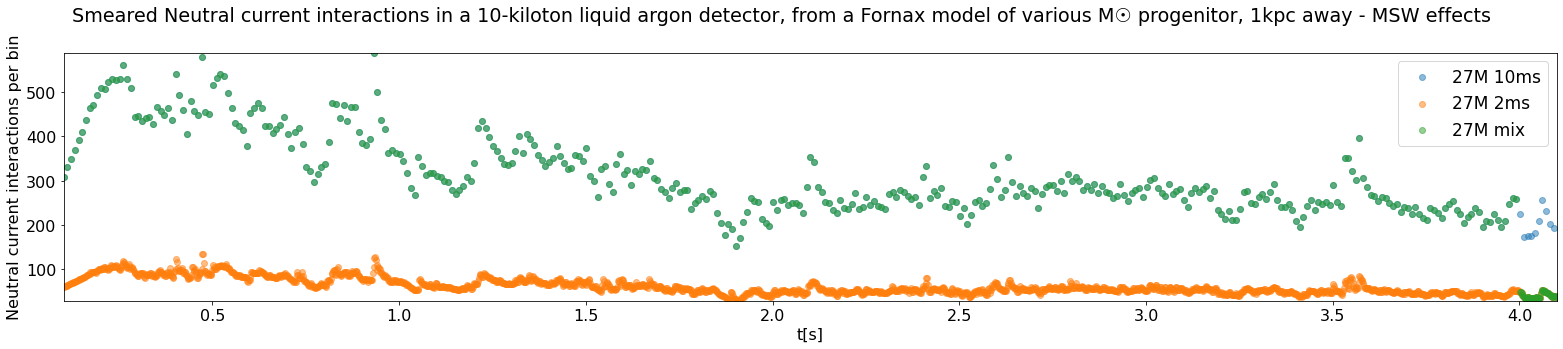

In [15]:
my_files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"
get_and_plot_multiple_int_interactions("nc", my_files, "20", "Fornax", "MSW")



390
50


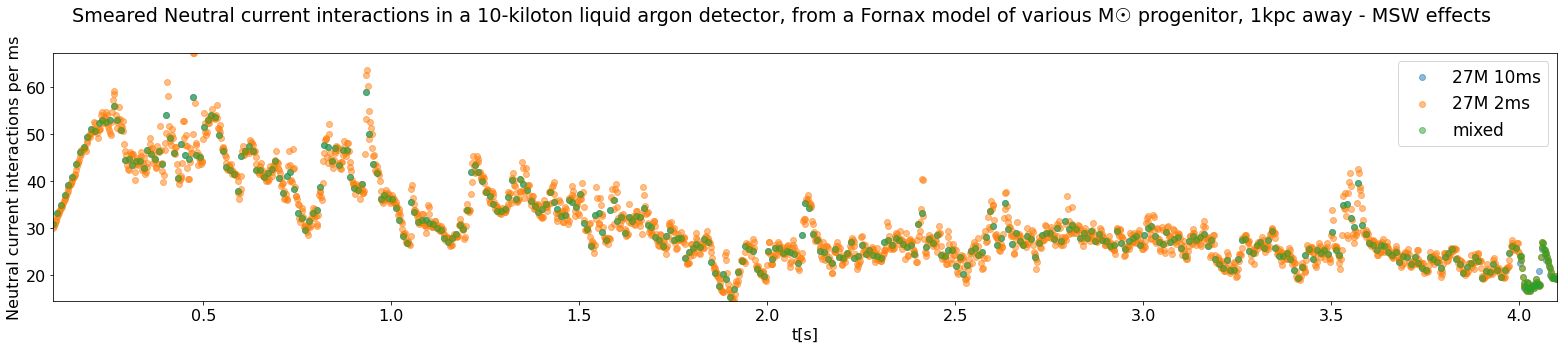

In [16]:
# can I make them the same per ms?

def get_and_plot_multiple_int_interactions(interaction, files, mass, model, msw):
    energy, channel_t, inst_interaction = [], [], []
    burst, cooling, high_res = [], [], []
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    local_max_location = 0
    overleaf_interaction = formatted_flavor(interaction)
    
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(22, 5), tight_layout=True)#, gridspec_kw={'width_ratios': [1, 2]})
    



    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 400 # .01 s time bin

    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 
    change_to_s = window_bins / (window_tend - window_tstart) / 1000
    
    high_res = []
    files = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/10ms/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test13, interaction, files)
    test13 = scale_detector(test13, high_res)   
    test13 = [value * change_to_s for value in test13]
    
    plot_blocks(test13, ax1, local_max_location, "27M 10ms", burst, tstart)
    
    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 2000 # .01 s time bin

    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    change_to_s = window_bins / (window_tend - window_tstart) / 1000
    files = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/2ms/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test16, interaction, files)
    #burst, cooling, high_res = sort_by_phase(window_tstart, window_tend)
    test16 = scale_detector(test16, high_res)
    test16 = [value * change_to_s for value in test16]
    plot_blocks(test16, ax1, local_max_location, "27M 2ms", burst, tstart)   
    
    
    
    window_tstart_burst = 0.1015 # Fornax adjusted time bins
    window_tend_burst = 4.0015
    window_bins_burst = 390 # .01 s time bin

    window_tstart = 4.0015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 50

    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 
    
    change_to_s = window_bins / (window_tend - window_tstart) / 1000

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 
    
    change_to_s_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) / 1000    

    tstart = np.append(tstart_burst, tstart)
    tend = np.append(tend_burst, tend)
    burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)    
    
    ## debug here
    files = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/mix/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    test16 = []
    testing = get_interaction_arrays(energy, inst_interaction, test16, interaction, files)
    #plot_blocks(testing, ax1, local_max_location, "unscaled", burst, tstart)
    
    test17 = []
    testing1 = get_interaction_arrays(energy, inst_interaction, test17, interaction, files)
    test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    plot_blocks(test2, ax1, local_max_location, "mixed", burst, tstart)   
    
    #finish

    ax1.set_xlabel("t[s]")
    ax1.set_ylabel(f"{overleaf_interaction} interactions per ms")
    #ax1.set_ylim(0,local_max)
    ax1.margins(0)

    ax1.legend(prop={'size': 17})


    
    plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from a {model} model of various M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{interaction}_{mass}_{model}_{msw}.png')
    plt.show()

my_files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"
get_and_plot_multiple_int_interactions("nc", my_files, "20", "Fornax", "MSW")




In [266]:
factor = window_bins / (window_tend - window_tstart) / 1000

files = "/Users/sierra/Desktop/neutrino/neutrino/test_12_6/Zha_2021_s17_AdiabaticMSW_NMO_SNOprocessed"

energy_inst, interaction_inst, channel_type = [], [], []

get_interaction_arrays(energy_inst, interaction_inst, channel_type, "all", files)


column 0 10.049999
column 1 16007.494072750002
column 2 500.05791117520016
column 3 762.6918241809998
column 4 13.9594135
column 5 174.86358916146503
sum of columns (except energy) is 17459.066810767665


In [267]:
print(sum(channel_type)/17459.043408289574)

1.0000013404215526


In [268]:
# now two bins

files = "/Users/sierra/Desktop/neutrino/neutrino/test_12_6/two/Zha_2021_s17_AdiabaticMSW_NMO_SNOprocessed"

energy_inst, interaction_inst, channel_type = [], [], []

get_interaction_arrays(energy_inst, interaction_inst, channel_type, "all", files)

print(sum(channel_type))

column 0 10.049999
column 1 7886.499570460005
column 2 260.40248636035506
column 3 381.93496663350004
column 4 6.986925325
column 5 84.81660242153
sum of columns (except energy) is 8620.64055120039
column 0 20.099998000000003
column 1 16007.497637390008
column 2 500.05777818194036
column 3 762.691924126
column 4 13.959409534999999
column 5 174.8635738997901
sum of columns (except energy) is 17459.07032313274
17459.070323132735


In [269]:
# now two bins, converted to ms

window_tstart = 0.742
window_tend = 0.762
window_bins = 2
tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False)
tend = tstart + (window_tend - window_tstart) / window_bins
tmid = (tstart + tend) * 0.5



files = "/Users/sierra/Desktop/neutrino/neutrino/test_12_6/two/Zha_2021_s17_AdiabaticMSW_NMO_SNOprocessed"

energy_inst, interaction_inst, channel_type = [], [], []

get_interaction_arrays(energy_inst, interaction_inst, channel_type, "all", files)



column 0 10.049999
column 1 7886.499570460005
column 2 260.40248636035506
column 3 381.93496663350004
column 4 6.986925325
column 5 84.81660242153
sum of columns (except energy) is 8620.64055120039
column 0 20.099998000000003
column 1 16007.497637390008
column 2 500.05777818194036
column 3 762.691924126
column 4 13.959409534999999
column 5 174.8635738997901
sum of columns (except energy) is 17459.07032313274


In [224]:
factor = window_bins / (window_tend - window_tstart) / 1000
channel_type = [x * factor for x in channel_type]
print(tstart, tend)
print(tmid)
print(channel_type)
print(sum(channel_type))
print(factor)

[0.742 0.752] [0.752 0.762]
[0.747 0.757]
[862.0640551200381, 883.8429771932338]
1745.9070323132719
0.09999999999999991


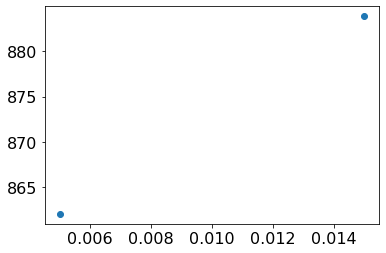

In [226]:
tmid
plt.scatter(tmid - .742, channel_type)
plt.show()

In [ ]:
my_files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"

window_tstart = 0.1015 # Fornax adjusted time bins
window_tend = 4.1015
window_bins = 800 # .005 s time bin

window_tstart_burst = -0.0505 # Fornax adjusted time bins
window_tend_burst = 0.1015
window_bins_burst = 76 # .002 s time bin


tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
tend = tstart + (window_tend - window_tstart) / window_bins 
tmid = (tstart + tend) * 0.5 

tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
tmid_burst = (tstart_burst + tend_burst) * 0.5 

tstart = np.append(tstart_burst, tstart)
tend = np.append(tend_burst, tend)

# rename factor
change_to_s = window_bins / (window_tend - window_tstart) / 1000
change_to_s_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) / 1000


coarse 1927.5711351842517
fine 21.306070891160964


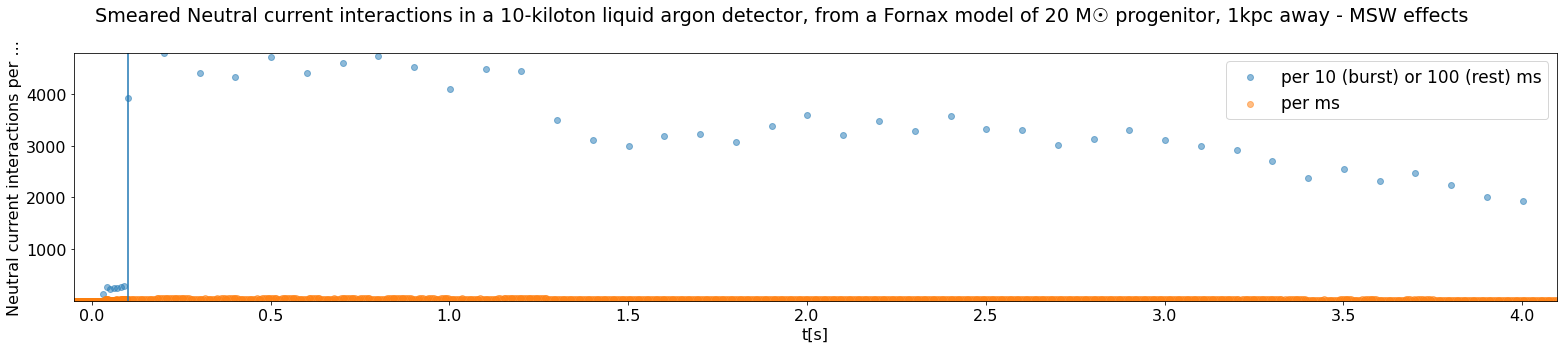

In [46]:
# can I make them the same per ms?

def get_and_plot_multiple_int_interactions(interaction, files, mass, model, msw):
    energy, channel_t, inst_interaction = [], [], []
    burst, cooling, high_res = [], [], []
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    local_max_location = 0
    overleaf_interaction = formatted_flavor(interaction)
    
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(22, 5), tight_layout=True)#, gridspec_kw={'width_ratios': [1, 2]})
    my_files = "/Users/sierra/Desktop/neutrino/neutrino/fornax_coarse/20M/Fornax_2021_lum_spec_20M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    
    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 40 # .1 s time bin

    window_tstart_burst = -0.0485 # Fornax adjusted time bins
    window_tend_burst = 0.1015
    window_bins_burst = 15 # .01 s time bin



    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)
    tend = np.append(tend_burst, tend)

    # rename factor
    factor_to_rescale = window_bins / (window_tend - window_tstart) 
    factor_to_rescale_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) 
    
    
    test17 = []
    testing1 = get_interaction_arrays(energy, inst_interaction, test17, interaction, my_files)
    testing2 = scale_detector(testing1, high_res)
    print("coarse", testing2[-1])
    #test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    plot_blocks(testing2, ax1, local_max_location, "per 10 (burst) or 100 (rest) ms", burst, tstart)  
    
    
    
    
    tstart = []
    my_files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"

    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 800 # .005 s time bin

    window_tstart_burst = -0.0505 # Fornax adjusted time bins
    window_tend_burst = 0.1015
    window_bins_burst = 76 # .002 s time bin


    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)

    tend = np.append(tend_burst, tend)

    # rename factor
    change_to_s = window_bins / (window_tend - window_tstart) / 1000
    change_to_s_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) / 1000 

    burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)    
    
    ## debug here
    #files = "/Users/sierra/Desktop/neutrino/neutrino/test_dir/mix/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    
    test17 = []
    testing1 = get_interaction_arrays(energy, inst_interaction, test17, interaction, my_files)
    test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    print("fine", test2[-1])
    plot_blocks(test2, ax1, local_max_location, "per ms", burst, tstart)   
    
    #finish

    ax1.set_xlabel("t[s]")
    ax1.set_ylabel(f"{overleaf_interaction} interactions per ...")
    #ax1.set_ylim(0,local_max)
    ax1.margins(0)

    ax1.legend(prop={'size': 17})

    plt.axvline(x=0.1015)

    
    plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from a {model} model of 20 M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{interaction}_{mass}_{model}_{msw}.png')
    plt.show()

my_files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"
get_and_plot_multiple_int_interactions("nc", my_files, "20", "Fornax", "MSW")




13M coarse 2762.1703892999994
16M coarse 2058.5860602499984
17M coarse 4032.8036564250006
20M coarse 3227.1740249000004
27M coarse 3279.387802775


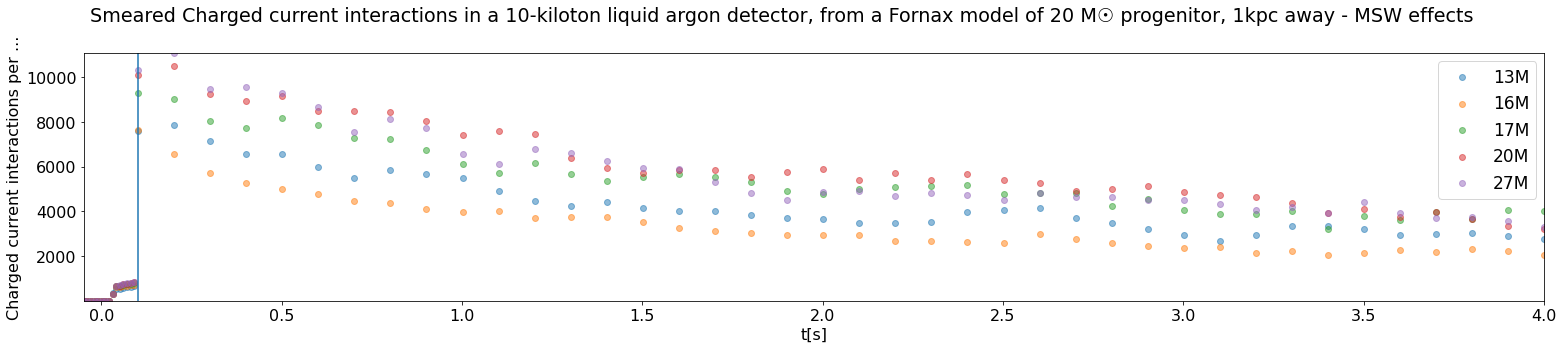

In [66]:
# can I make them the same per ms?

def get_and_plot_multiple_int_interactions(interaction, files, mass, model, msw):
    energy, channel_t, inst_interaction = [], [], []
    burst, cooling, high_res = [], [], []
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    local_max_location = 0
    overleaf_interaction = formatted_flavor(interaction)
    
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(22, 5), tight_layout=True)#, gridspec_kw={'width_ratios': [1, 2]})
        
    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 40 # .1 s time bin

    window_tstart_burst = -0.0485 # Fornax adjusted time bins
    window_tend_burst = 0.1015
    window_bins_burst = 15 # .01 s time bin



    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)
    tend = np.append(tend_burst, tend)

    # rename factor
    factor_to_rescale = window_bins / (window_tend - window_tstart) 
    factor_to_rescale_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) 
    
    
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    energy_test, inst_interaction = [],[]
    files = "/Users/sierra/Desktop/neutrino/neutrino/fornax_coarse/Fornax_2021_lum_spec_13M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    testing1 = get_interaction_arrays(energy, inst_interaction, test13, interaction, files)
    testing2 = scale_detector(testing1, high_res)
    print("13M coarse", testing2[-1])
    #test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    plot_blocks(testing2, ax1, local_max_location, "13M", burst, tstart)      
    
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/fornax_coarse/Fornax_2021_lum_spec_16M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    testing1 = get_interaction_arrays(energy, inst_interaction, test16, interaction, files)
    testing2 = scale_detector(testing1, high_res)
    print("16M coarse", testing2[-1])
    #test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    plot_blocks(testing2, ax1, local_max_location, "16M", burst, tstart)   
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/fornax_coarse/Fornax_2021_lum_spec_17M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    testing1 = get_interaction_arrays(energy, inst_interaction, test17, interaction, files)
    testing2 = scale_detector(testing1, high_res)
    print("17M coarse", testing2[-1])
    #test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    plot_blocks(testing2, ax1, local_max_location, "17M", burst, tstart)   
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/fornax_coarse/20M/Fornax_2021_lum_spec_20M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    testing1 = get_interaction_arrays(energy, inst_interaction, test20, interaction, files)
    testing2 = scale_detector(testing1, high_res)
    print("20M coarse", testing2[-1])
    #test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    plot_blocks(testing2, ax1, local_max_location, "20M", burst, tstart)   
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/fornax_coarse/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    testing1 = get_interaction_arrays(energy, inst_interaction, test27, interaction, files)
    testing2 = scale_detector(testing1, high_res)
    print("27M coarse", testing2[-1])
    #test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    plot_blocks(testing2, ax1, local_max_location, "27M", burst, tstart)   
    
    #finish

    ax1.set_xlabel("t[s]")
    ax1.set_ylabel(f"{overleaf_interaction} interactions per ...")
    #ax1.set_ylim(0,local_max)
    ax1.margins(0)

    plt.axvline(x=0.1015)
    
    ax1.legend(prop={'size': 17})

    plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from a {model} model of 20 M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{interaction}_{mass}_{model}_{msw}.png')
    plt.show()

my_files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"
get_and_plot_multiple_int_interactions("cc", my_files, "20", "Fornax", "MSW")




13M fine 27.4352693355
16M fine 20.629030356000005
17M fine 37.85377908749999
20M fine 34.65233057400004
27M fine 32.61054944300001


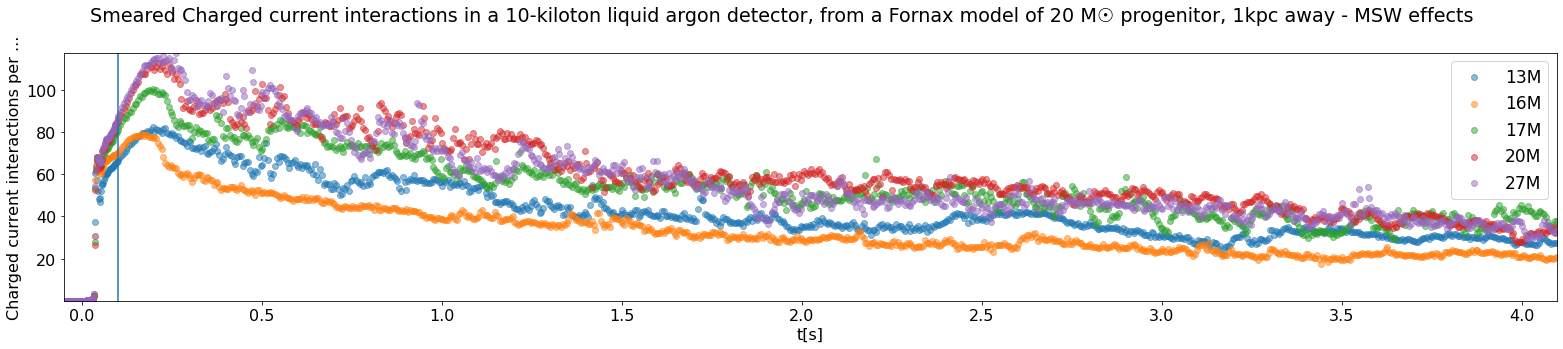

In [65]:
# can I make them the same per ms?

def get_and_plot_multiple_int_interactions(interaction, files, mass, model, msw):
    energy, channel_t, inst_interaction = [], [], []
    burst, cooling, high_res = [], [], []
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    local_max_location = 0
    overleaf_interaction = formatted_flavor(interaction)
    
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(22, 5), tight_layout=True)#, gridspec_kw={'width_ratios': [1, 2]})
    
    
    
    tstart = []

    window_tstart = 0.1015 # Fornax adjusted time bins
    window_tend = 4.1015
    window_bins = 800 # .005 s time bin

    window_tstart_burst = -0.0505 # Fornax adjusted time bins
    window_tend_burst = 0.1015
    window_bins_burst = 76 # .002 s time bin


    tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
    tend = tstart + (window_tend - window_tstart) / window_bins 
    tmid = (tstart + tend) * 0.5 

    tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
    tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
    tmid_burst = (tstart_burst + tend_burst) * 0.5 

    tstart = np.append(tstart_burst, tstart)

    tend = np.append(tend_burst, tend)

    # rename factor
    change_to_s = window_bins / (window_tend - window_tstart) / 1000
    change_to_s_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) / 1000 

    burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)    
    
    ## debug here
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    energy_test, inst_interaction = [],[]
    files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/13M"
    testing1 = get_interaction_arrays(energy, inst_interaction, test13, interaction, files)
    test2 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    print("13M fine", test2[-1])
    plot_blocks(test2, ax1, local_max_location, "13M", burst, tstart)  
    
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/16M"
    testing1 = get_interaction_arrays(energy, inst_interaction, test16, interaction, files)
    test3 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    print("16M fine", test3[-1])
    plot_blocks(test3, ax1, local_max_location, "16M", burst, tstart)  
    
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/17M"
    testing1 = get_interaction_arrays(energy, inst_interaction, test17, interaction, files)
    test4 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    print("17M fine", test4[-1])
    plot_blocks(test4, ax1, local_max_location, "17M", burst, tstart)  
    
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"
    testing1 = get_interaction_arrays(energy, inst_interaction, test20, interaction, files)
    test5 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    print("20M fine", test5[-1])
    plot_blocks(test5, ax1, local_max_location, "20M", burst, tstart)  
    
    
    files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/26.99M"
    testing1 = get_interaction_arrays(energy, inst_interaction, test27, interaction, files)
    test6 = scale_detector_res(testing1, burst, change_to_s_burst, change_to_s) # i think this is updating the reference not the object.... 
    print("27M fine", test6[-1])
    plot_blocks(test6, ax1, local_max_location, "27M", burst, tstart)  
    
        
    
    #finish

    ax1.set_xlabel("t[s]")
    ax1.set_ylabel(f"{overleaf_interaction} interactions per ...")
    #ax1.set_ylim(0,local_max)
    ax1.margins(0)

    ax1.legend(prop={'size': 17})

    plt.axvline(x=0.1015)

    
    plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from a {model} model of 20 M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{interaction}_{mass}_{model}_{msw}.png')
    plt.show()

my_files = "/Users/sierra/Desktop/neutrino/neutrino/snowglobes_runs_20_solar_mass/fornax_2021_by_mass/interactions/20M"
get_and_plot_multiple_int_interactions("cc", my_files, "20", "Fornax", "MSW")


